In [9]:
import ingestor, modeller, fitter
import matplotlib.pyplot as plt
import numpy as np

In [21]:
from importlib import reload
reload(ingestor)
reload(modeller)
reload(fitter)

<module 'fitter' from '/media/dwu402/Data/wrap-mad/fitter.py'>

In [36]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = [15, 10]

from cycler import cycler

new_color = cycler(color=["k"])
plt.rcParams['axes.prop_cycle'] = plt.rcParams['axes.prop_cycle'].concat(new_color)

In [14]:
context = ingestor.Context("runs/minimal4.3.run")

In [29]:
model = modeller.Model(context)

In [ ]:
solver = fitter.Fitter()

In [33]:
def replace(l, idx, val):
    return l[:idx] + [val] + l[idx+1:]
getx = fitter.ca.Function("getx", [model.ts, *model.cs], model.xs)

In [30]:
solver.construct_objectives(context, model)
solver.construct_problems()

In [31]:
solver.solve(1)

In [28]:
context.update('fitting_configuration', {'regularisation_parameter': replace(context.fitting_configuration['regularisation_parameter'], 2, 0.001)})

In [39]:
solver.outer_objectives

[<function fitter.Fitter.outer_function.<locals>.H(c, p, rho=None)>]

[0.3950404  1.5227826  1.08579279 0.68123952 1.50433842 0.43316832
 1.08599564 0.66348007 0.3508616  2.18298352 1.44375566]
[[ 0.00735415 -0.21704679 -0.769161  ]]


Text(0.5, 0, 'time, t')

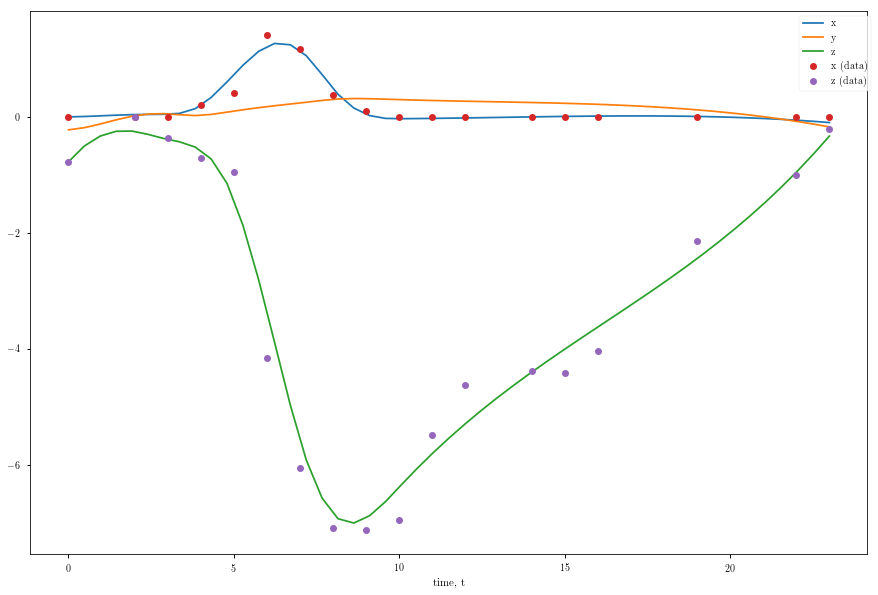

In [37]:
target_rho = 1
c_end = solver.problems[0].cache.results[fitter.tokey(target_rho, solver.solutions[str(target_rho)][0].x)].x
print(solver.solutions[str(target_rho)][0].x)
xs_end = np.array([np.array(i) for i in getx(model.observation_times, 
                                         *fitter.argsplit(c_end, 
                                                          3)
                                        )])
print(xs_end[:,0].T)
plt.plot(model.observation_times, np.hstack([xs_end[0], xs_end[1], xs_end[2]]),
         context.datasets[0]['t'], context.datasets[0]['x'], 'o',
         context.datasets[0]['t'], context.datasets[0]['z'], 'o')
plt.legend(list("xyz") + ["x (data)", "z (data)"], loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("time, t")

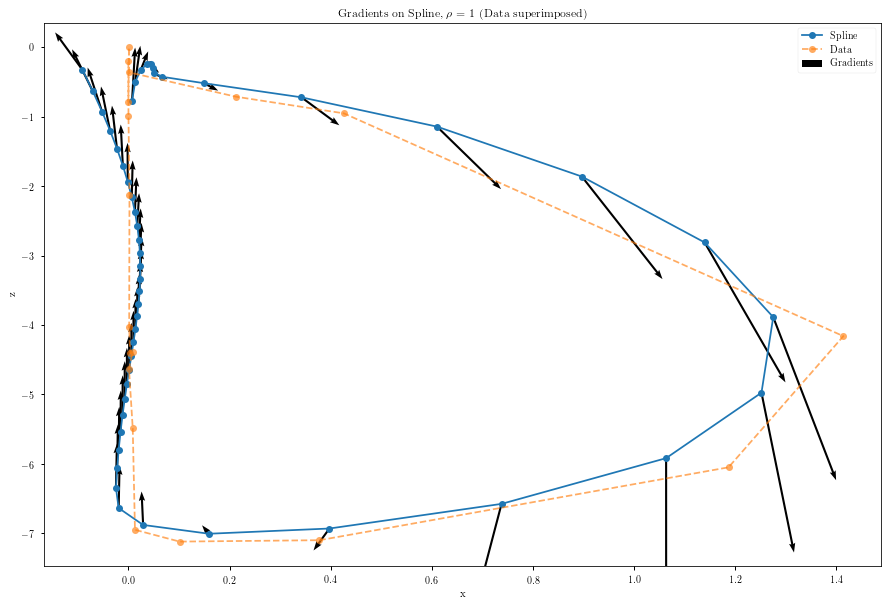

In [38]:
spline_dfield = np.array([context.model(t, xs_end[:,i], solver.solutions[str(target_rho)][0].x) 
                 for i,t in enumerate(model.observation_times)])

spline_dfield = spline_dfield.reshape(spline_dfield.shape[:2])

plt.plot(xs_end[0], xs_end[2], 'o-')
plt.plot(context.datasets[0]['x'], context.datasets[0]['z'], 'o--', alpha=0.65)
plt.quiver(xs_end[0], xs_end[2], spline_dfield[:,0], spline_dfield[:,2], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho} (Data superimposed)")
plt.xlabel("x")
plt.ylabel("z")
plt.legend(["Spline", "Data", "Gradients"])